In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt') 
from IPython.display import clear_output


from API_Reddit.comments_extractor import comments_extractor
from TextAnalysis.preprocessor import TextPreprocessor
from TextAnalysis.descriptive_statistics_and_visalization import word_length_distribution, calculate_word_statistics, plot_most_frequent_words
from TextAnalysis.words_replacing import WordReplacer
from TextAnalysis.stem_and_lem  import TextStemLem
from TextAnalysis.pre_prepocessing import hash_text, change_time_format
from TextAnalysis.word_mapping import word_mapping
from TextAnalysis.sentiment_analysis_over_time import analyze_sentiment
from TextAnalysis.word_embedding import create_word_embeddings

clear_output()

Note: there might be some problems with the importing some libraries (like gensim) to the terminal and then running the import in the Jupyter notebook. If you cannot import them and Python says about unresolved imports, try this:
```py
!python -m pip install -U gensim
```
Just put in the cell of the Jupyter Notebook, install an restart everything.

---

# Exctraction of comments using Reddit API

In [ ]:
# Two distinct dataframes are created. It takes a few minute to extract all comments, 
# so consider making tea in the meantime

comments_after_win = comments_extractor('ACMilan', '17pzwvv') 
comments_after_lose = comments_extractor('ACMilan', '17gb1xz')

 If you do not want to waste your time running the code over and over again to download comments aftere there is so mistake, consider downloading data to a csv file and name it the way you like. After that just assign in to a variable. For example:

```py
comments_after_lose.to_csv('milan_lost.csv', index=False)
sad_comments = pd.read_csv('milan_lost.csv')
```

I will continue with the previous names of the dataframe.

In [2]:
comments_after_lose = pd.read_csv('milan_lost.csv')
comments_after_win = pd.read_csv('milan_win.csv')

You can check that everything is ok just by writing the name(s) of a DataFrame and running the code. Before that, however, I want to apply two functions that allow me to present the better version of the data:
- I want to hash the names of people leaving commets
- change the date_time representation so that it is more user-friendly

To do so, I use functions from the "pre_preprocessing" module from the TextAnalysis Folder.

In [3]:
# Firstly I hash the 'author' columns in both dataframes
comments_after_win = hash_text(comments_after_win,column_name='author')
comments_after_lose = hash_text(comments_after_lose,column_name='author')

# Then I change the format of the representation of date and time
comments_after_win = change_time_format(comments_after_win,column_name='created_utc')
comments_after_lose = change_time_format(comments_after_lose,column_name='created_utc')

#Lastly, to each of the dataframes I add a column with the results of the match: win or lose
comments_after_win['match_status'] = 'win'
comments_after_lose['match_status'] = 'lose'
# It will be needed for word embedding,

---

### The DataFrames afrer pre_prepocessing:

In [4]:
comments_after_lose.head(5)

,author,body,created_datetime,match_status
0,61fd7167a2,"This Is a ""sack pioli"" game",2023-10-25 20:32:01,lose
1,994a9e8f5a,Fenerbahce please come and take your Krunic,2023-10-25 19:37:16,lose
2,fc04ec1d74,People saying Pioli will definitely be fired d...,2023-10-25 20:56:32,lose
3,3b185f4240,Krunic owes me 3 mil a year for having to watc...,2023-10-25 19:36:30,lose
4,92311e8579,There is absolutely no way we are scoring today,2023-10-25 19:39:27,lose


In [5]:
comments_after_win.head(5)

,author,body,created_datetime,match_status
0,e747f9104e,This is the match thread for today's match. We...,2023-11-07 17:47:32,win
1,c781e57654,RLC was a different type of animal today holy ...,2023-11-07 22:02:38,win
2,b7aa5347ca,Rafa has been world class tonight he’s been ru...,2023-11-07 21:42:52,win
3,e52216b2a4,So RLC was the signing of the summer? Confirmed?,2023-11-07 20:51:49,win
4,439667f389,Calabria pocketing another superstar LW :),2023-11-07 21:59:58,win


---

# Preprocessing Stage

#### Now we use quite a few function to preprocess data
Consult with the "preprocessor", "words_replacing"and "stem_and_lem" modules in the TextAnalysis folder. All the documentation is written there.

After the execution of the comments we expect the text to be:
- In lower case;
- Without any links;
- Without punctuation;
- Without stopwords (words that don't have much meaning);
- Without any special characters;
- Contaning only words with more than 2 letters (to avoid nonsense words that might appear during previous stages);
- With curse words masked;
  
Additionally, I manually replace some of the words as long as they refer to the same thing(person) but are treated differently when analyzing data. Mainly, it concerns surnames of the players. For example, Christian Pulisic can be addressed by "Puli" and "Pulisich" by the fans of Milan; or "RCL" is a "Ruben Loftus-Cheek". No python library can trace it, so I have to manually change it if I notice something. It can surely impact the analysis of the comments, but there is no recearch withou limitations.  For that, I use "words_replacing" module in the TextAnalysis folder.

Lastly, I want to add two columns to the dataframe: one with stemmed words and another with lemmatized words. Those are nedded as I want to compare text of I receive after preprocessing with even "purer" data to have just a better view of the situation. For that, I use "stem_and_lem" module in the TextAnalysis folder.

We have to make instances of the class TextProcessor to apply all the functions:

In [6]:
preprocessor_lose = TextPreprocessor(comments_after_lose)
preprocessor_win = TextPreprocessor(comments_after_win)

After that we create dataframes out of the instances:

In [7]:
# body -- the name of the column that contains the text of the comments
preprocessed_lose_df = preprocessor_lose.apply_all('body')
preprocessed_win_df = preprocessor_win.apply_all('body')

Now we can look what we get:

In [8]:
preprocessed_lose_df.head(5)

,author,body,created_datetime,match_status
0,61fd7167a2,sack pioli game,2023-10-25 20:32:01,lose
1,994a9e8f5a,fenerbahce come krunic,2023-10-25 19:37:16,lose
2,fc04ec1d74,people saying pioli definitely fired realise p...,2023-10-25 20:56:32,lose
3,3b185f4240,krunic owes mil year having watch ga*****,2023-10-25 19:36:30,lose
4,92311e8579,absolutely way scoring today,2023-10-25 19:39:27,lose


In [9]:
preprocessed_win_df.head(5)

,author,body,created_datetime,match_status
0,e747f9104e,match thread todays match testing new feature ...,2023-11-07 17:47:32,win
1,c781e57654,rlc different type animal today holy sh****,2023-11-07 22:02:38,win
2,b7aa5347ca,rafa world class tonight running like crazy,2023-11-07 21:42:52,win
3,e52216b2a4,rlc signing summer confirmed,2023-11-07 20:51:49,win
4,439667f389,calabria pocketing superstar,2023-11-07 21:59:58,win


Now let's turn to the replacement of the word that refer to the same person:

In [10]:
# We firstly create two instances of the WordReplacer class
word_replacer_win = WordReplacer(preprocessed_win_df)
word_replacer_lose = WordReplacer(preprocessed_lose_df)

#Then we create two dataframes (I name them the same way to avoid the confusion)
# and we use the dictionary 'word_mapping' from the respective module.
preprocessed_win_df = word_replacer_win.replace_words('body', word_mapping)
word_replacer_lose = word_replacer_lose.replace_words('body', word_mapping)

In [11]:
preprocessed_win_df.head(5) #It works, as we have "leao" instead of "rafa".

,author,body,created_datetime,match_status
0,e747f9104e,match thread todays match testing new feature ...,2023-11-07 17:47:32,win
1,c781e57654,rlc different type animal today holy sh****,2023-11-07 22:02:38,win
2,b7aa5347ca,leao world class tonight running like crazy,2023-11-07 21:42:52,win
3,e52216b2a4,rlc signing summer confirmed,2023-11-07 20:51:49,win
4,439667f389,calabria pocketing superstar,2023-11-07 21:59:58,win


##### Now we can proceede with adding columns with stemmed and lemmatized words:

In [12]:
# We firstly create two instances of the TextStemLem class:
tsl_w = TextStemLem(preprocessed_win_df)
tsl_l = TextStemLem(preprocessed_lose_df)

# Then we add a column with stemmed words
tsl_w.stem_words('body')
tsl_l.stem_words('body')

# Finally, we add a column with lemmatized words
tsl_w.lemmatize_words('body')
tsl_l.lemmatize_words('body')

clear_output()

In [13]:
preprocessed_win_df = tsl_w.dataframe
preprocessed_lose_df = tsl_l.dataframe

In [14]:
preprocessed_win_df.head(5) # As you can see, everything works
# and we are done with the preprocessing part

,author,body,created_datetime,match_status,stemmed_words,lemmatized_words
0,e747f9104e,match thread todays match testing new feature ...,2023-11-07 17:47:32,win,match thread today match test new featur reddi...,match thread today match testing new feature r...
1,c781e57654,rlc different type animal today holy sh****,2023-11-07 22:02:38,win,rlc differ type anim today holi sh****,rlc different type animal today holy sh****
2,b7aa5347ca,leao world class tonight running like crazy,2023-11-07 21:42:52,win,leao world class tonight run like crazi,leao world class tonight running like crazy
3,e52216b2a4,rlc signing summer confirmed,2023-11-07 20:51:49,win,rlc sign summer confirm,rlc signing summer confirmed
4,439667f389,calabria pocketing superstar,2023-11-07 21:59:58,win,calabria pocket superstar,calabria pocketing superstar


Now let's download the datasets that we get after applying all functions. We will need it later when we use streamlit app for sentiment analysis and wordclouds. 

In [ ]:
preprocessed_win_df.to_csv('final_df_win.csv',index=False)
preprocessed_lose_df.to_csv('final_df_lose.csv',index=False)

---

# Descriptive Statistics

To get the descriptive statistics, I use functions from the "descriptive_statistics" module in the TextAnalysis folder.
There are three functions:

1) word_length_distribution: It returns histograms with the distribution of words in columns
2) calculate_word_statistics: It returns a DataFrame with the statistics about the words (total number of words, number of unique words, average length, median word lenght)
3) plot_most_frequent_words: It returns histograms with the most frequently used words (number is arbitrary, by default it is 10

As long as I apply this function to the columns 'body', 'stemmed_words', and 'lemmatized_words', there should be a list of them to apply functions simultanitously. 

In [15]:
# create a list with column names 
columns_list = ['body', 'stemmed_words', 'lemmatized_words']

Let's see at the histogram with the words' length distribution:

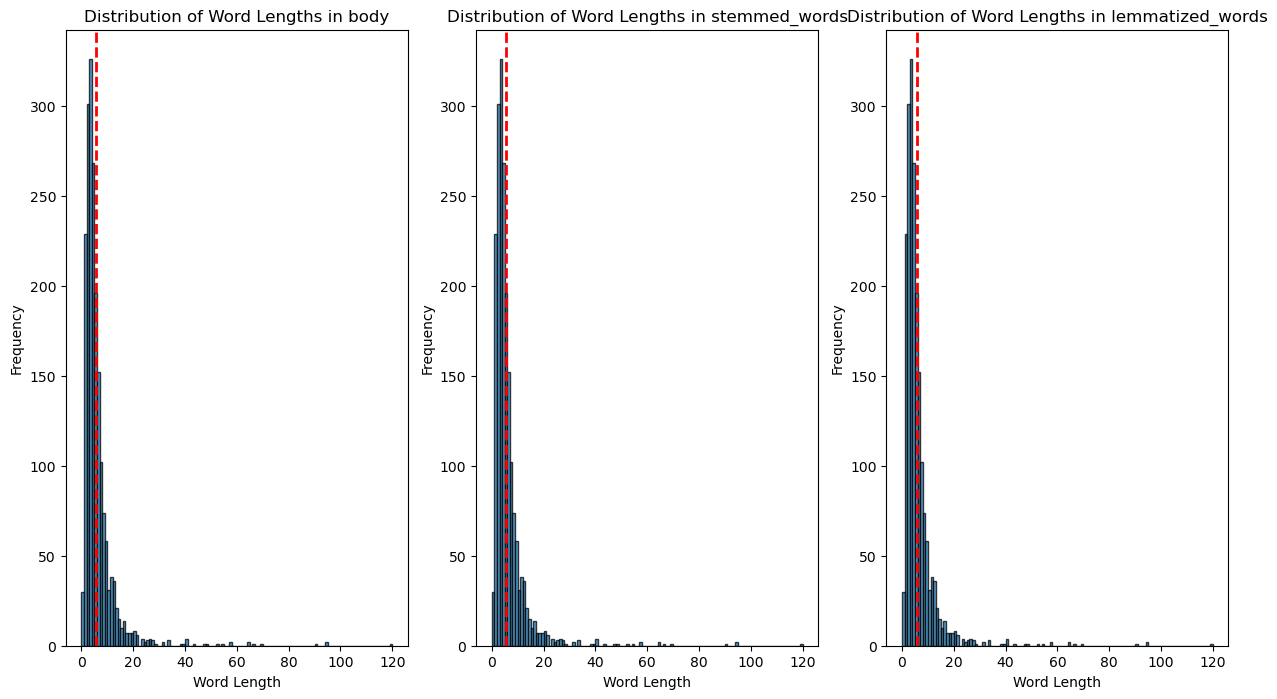

In [16]:
word_length_distribution(preprocessed_win_df, columns_list,figsize=(5,8))

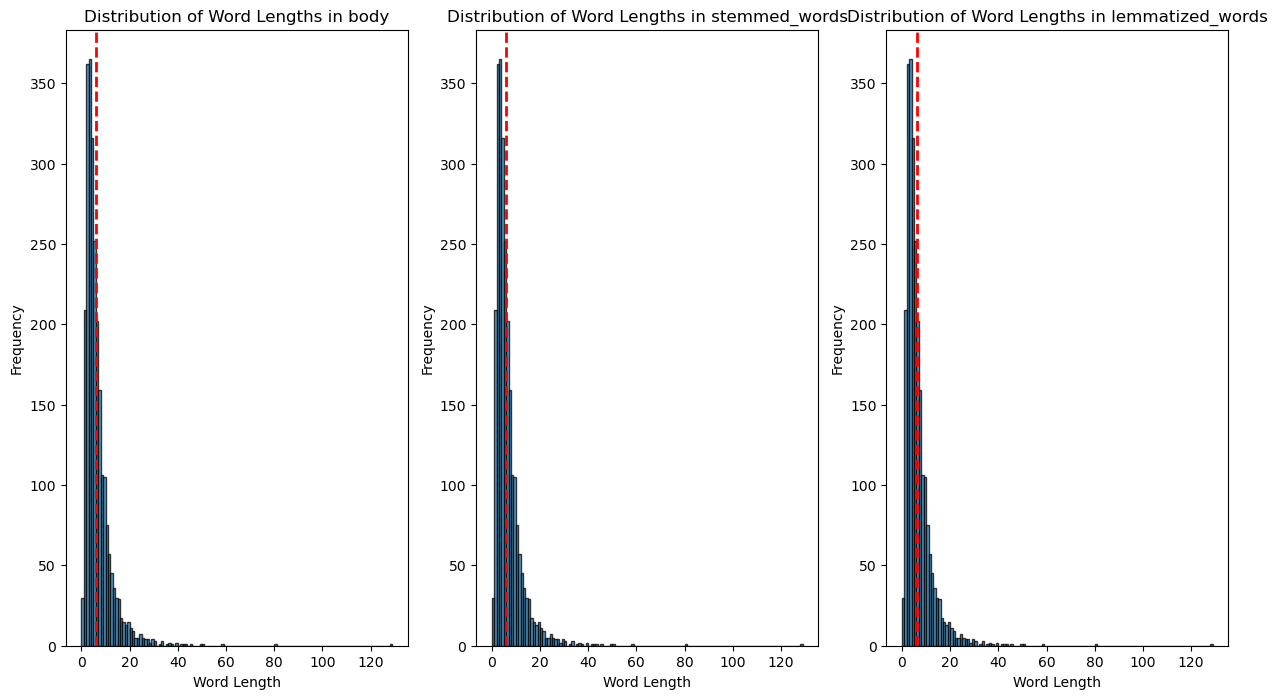

In [17]:
word_length_distribution(preprocessed_lose_df, columns_list,figsize=(5,8))

Then let's see at the descriptive statistics concerning the words usage:

In [18]:
calculate_word_statistics(preprocessed_win_df, columns_list)

,Column_Name,Total_Words,Unique_Words,Avg_Word_Length,Median_Word_Length
0,body,11127,2897,5.622537,4.0
1,stemmed_words,11127,2315,5.622537,4.0
2,lemmatized_words,11127,2703,5.622537,4.0


In [19]:
calculate_word_statistics(preprocessed_lose_df, columns_list)

,Column_Name,Total_Words,Unique_Words,Avg_Word_Length,Median_Word_Length
0,body,15247,3380,6.060016,4.0
1,stemmed_words,15247,2642,6.060016,4.0
2,lemmatized_words,15247,3169,6.060016,4.0


Lastly, lets see at the most used words in the comments after the both games:

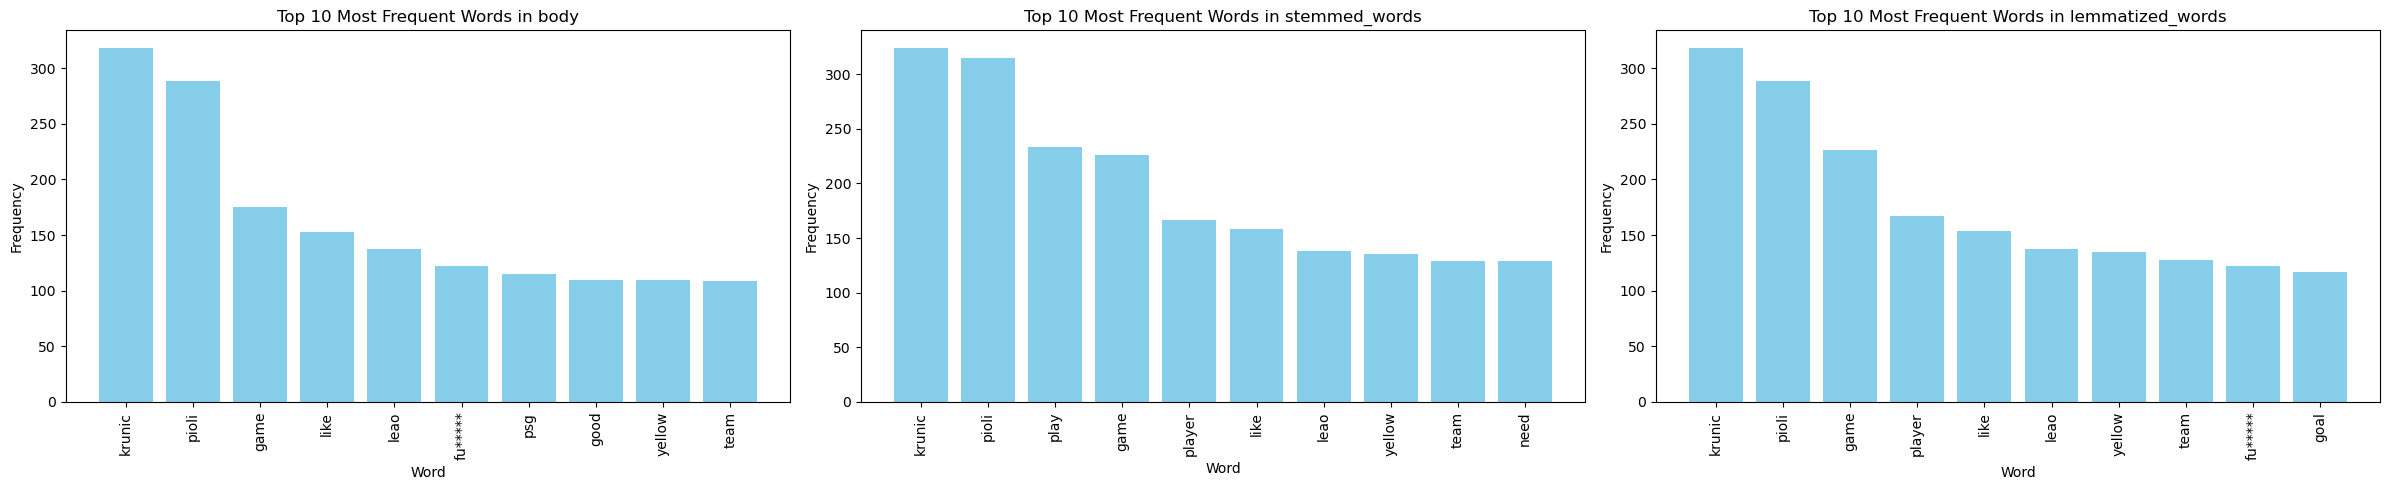

In [20]:
plot_most_frequent_words(preprocessed_lose_df,columns_list)

![text](https://media.tenor.com/dqg1ZF6kV1QAAAAd/stefano-pioli.gif) 

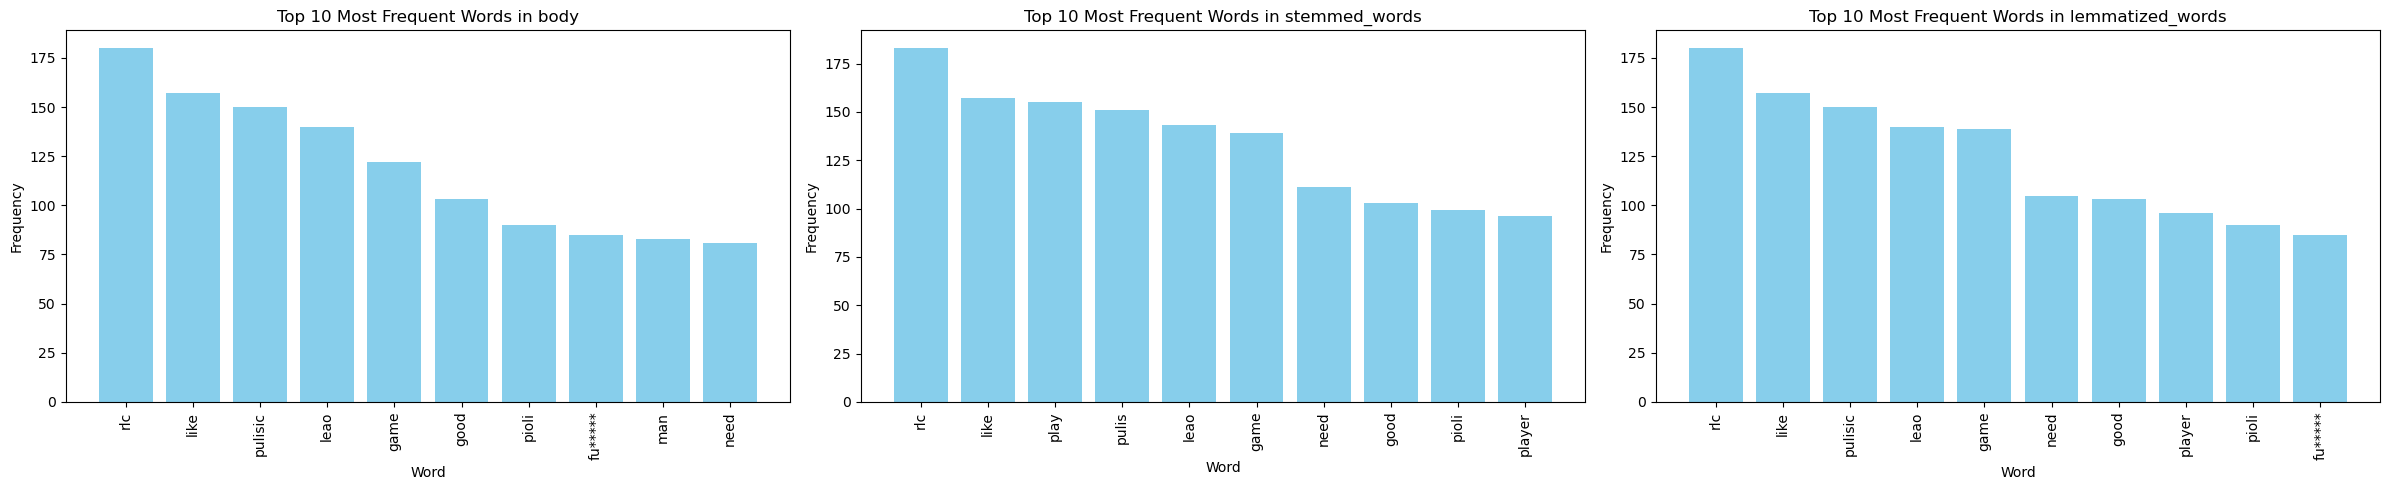

In [21]:
plot_most_frequent_words(preprocessed_win_df,columns_list, 10)

![text](https://media.tenor.com/uPwQKavXb2QAAAAC/heiitse-cfc.gif)

What we can see from these histograms:
1. When Milan lost, fans blamed Krunić (a player of Milan that played badly) and Pioli (the coach of Milan; he also frequently pick Krunić for the main squad, causing negative sentiment often).
2. We also see that they adressed  Leao and the team in general in their comments (blaming it as a whole).
3. When Milan won, they praised Ruben Loftus-Cheek, Pulisic and Leao.
4. They also addres the coach of Milan (from the actual text fans mostly joke about his love to use Krunić in every game, strategy and another match when he saved himself from being fired).

---

# Sentiment Analysis

Now we proceede with the sentiment analysis. Consult with the 'sentiment_analysis_over_time' module.

In [22]:
# In the function we are going to use, we need to insert the date of the match. I prefer to create a variable for that, 
# but you can directly insert the dates it is written here. Note that you have to insert either of those dates, and the time: 20 and 23.
# If not, the graph will not appear as intended (see it yourself in the title of the graph).
the_day_milan_lost = '2023-10-25'
the_day_milan_won = '2023-11-07'

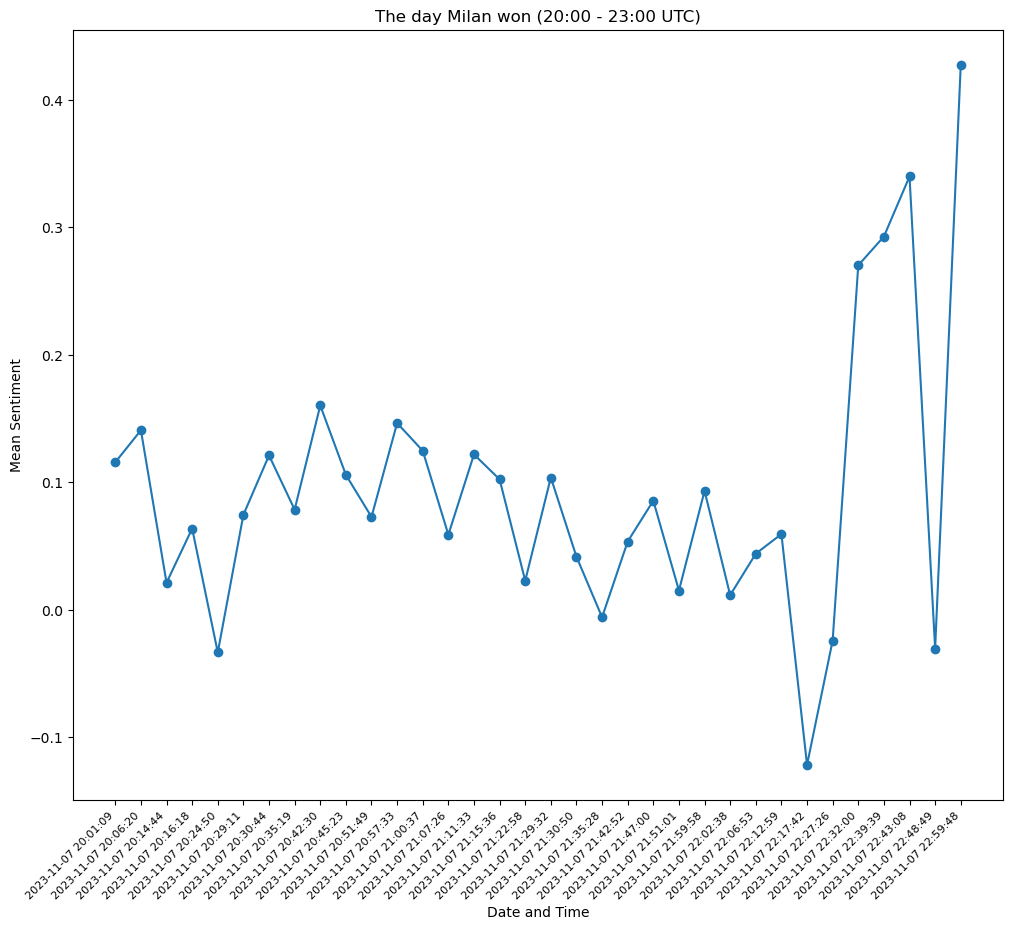

In [23]:
# Assuming your DataFrame is named 'preprocessed_win_df'
# Replace 'YourColumnName' with the actual column names in your DataFrame

# Use the function with your specific parameters
analyze_sentiment(preprocessed_win_df, the_day_milan_won, 20, 23, interval_minutes=5)

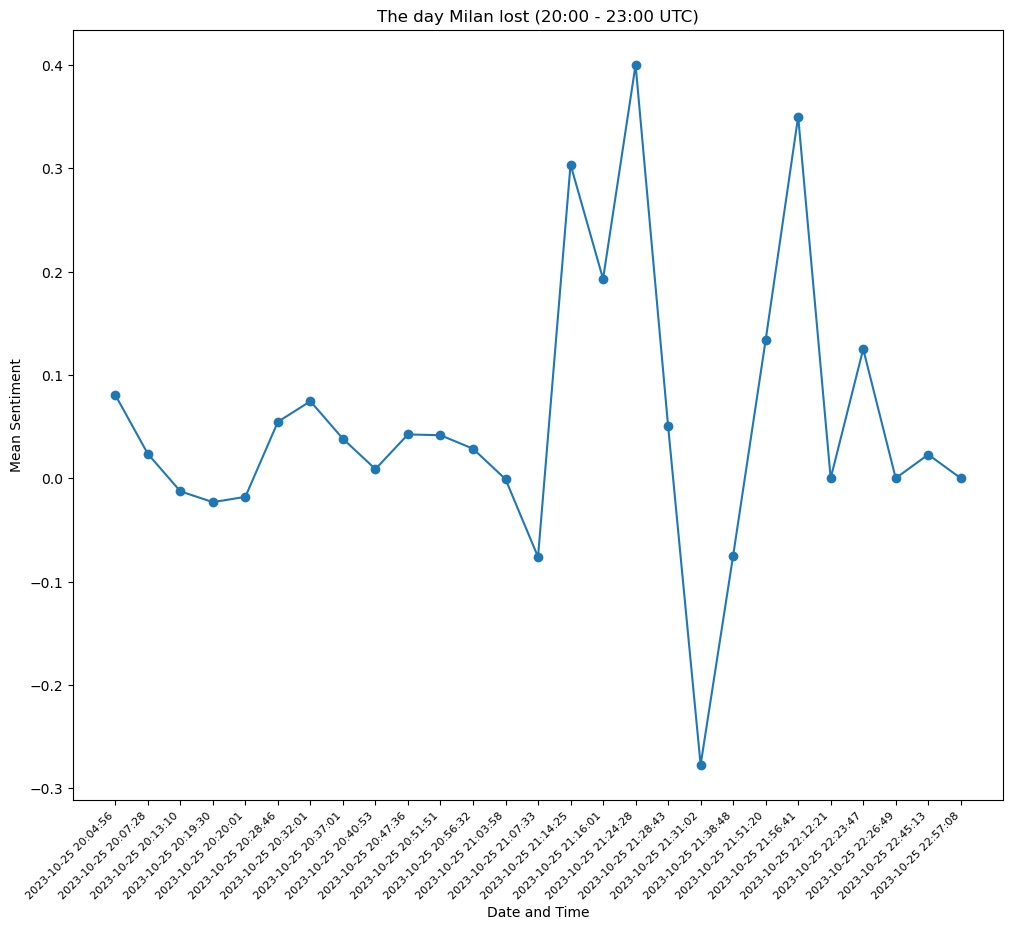

In [24]:
analyze_sentiment(preprocessed_lose_df, the_day_milan_lost, 20, 23, interval_minutes=5)

In most of the cases, sentiment is neutral (interval for that is from -0.5 and 0.5). Interesting that there is a spike in the 'positivity' (even though it is not positive as it does not near 0.5) after the match has finished (probably fans could not believe in that and were able to write something good on Reddit only one hour after the game finished).

---

# Word Embedding and Classifier

## DISCLAIMER:
This section was supposed to use the embeddings as features for a machine learning model to classify comments into different categories. And then to train a classifier to predict the 'win' or 'lose' status based on comment embeddings.

However, there are quite a few problems related to my particular case
1) I use comments to only 2 games, which is definetely not enough to build more or less useful moder
2) I use reddit commets (well, you can see how people talk on reddit, their comments rarely make sense. So the source of data is also important to consider).
3) I do not use games that resulted in a draw.
   
And so on...

They surely hinders the development of an adequate model with more or less high accuraty of prediction capacity.

Even though I realize te presence of the problems, I anyway created the model for fun (and to demonstrate that I can copy YouTube tutorials on word embedding). Have fun!

Lets firstly concatinate the two dataframes:

In [25]:
concatenated_df = pd.concat([preprocessed_win_df, preprocessed_lose_df], axis=0, ignore_index=True)

In [26]:
concatenated_df.head(5)

,author,body,created_datetime,match_status,stemmed_words,lemmatized_words
0,e747f9104e,match thread todays match testing new feature ...,2023-11-07 17:47:32,win,match thread today match test new featur reddi...,match thread today match testing new feature r...
1,c781e57654,rlc different type animal today holy sh****,2023-11-07 22:02:38,win,rlc differ type anim today holi sh****,rlc different type animal today holy sh****
2,b7aa5347ca,leao world class tonight running like crazy,2023-11-07 21:42:52,win,leao world class tonight run like crazi,leao world class tonight running like crazy
3,e52216b2a4,rlc signing summer confirmed,2023-11-07 20:51:49,win,rlc sign summer confirm,rlc signing summer confirmed
4,439667f389,calabria pocketing superstar,2023-11-07 21:59:58,win,calabria pocket superstar,calabria pocketing superstar


Then we apply function called 'create_word_embeddings' from the 'word_embedding' module. In the arguments you should write the column you want to have embedded words from. Actually, as the future analysis shows, it does not matter if you indicate 'body', 'stemmed_words', or 'lemmatized_words' in the argument. The model accuracy is the same (and pretty low).

In [27]:
create_word_embeddings(concatenated_df,'body')
clear_output()

In [28]:
concatenated_df.head(5)

,author,body,created_datetime,match_status,stemmed_words,lemmatized_words,tokenized_comments,comment_embeddings
0,e747f9104e,match thread todays match testing new feature ...,2023-11-07 17:47:32,win,match thread today match test new featur reddi...,match thread today match testing new feature r...,"[match, thread, todays, match, testing, new, f...","[-0.065544665, 0.084688656, 0.04933214, -0.000..."
1,c781e57654,rlc different type animal today holy sh****,2023-11-07 22:02:38,win,rlc differ type anim today holi sh****,rlc different type animal today holy sh****,"[rlc, different, type, animal, today, holy, sh...","[-0.09144728, 0.119496115, 0.05906358, 0.01260..."
2,b7aa5347ca,leao world class tonight running like crazy,2023-11-07 21:42:52,win,leao world class tonight run like crazi,leao world class tonight running like crazy,"[leao, world, class, tonight, running, like, c...","[-0.12655732, 0.15731215, 0.088578686, -0.0029..."
3,e52216b2a4,rlc signing summer confirmed,2023-11-07 20:51:49,win,rlc sign summer confirm,rlc signing summer confirmed,"[rlc, signing, summer, confirmed]","[-0.058420323, 0.07217195, 0.040675174, 0.0035..."
4,439667f389,calabria pocketing superstar,2023-11-07 21:59:58,win,calabria pocket superstar,calabria pocketing superstar,"[calabria, pocketing, superstar]","[-0.0453279, 0.061530333, 0.030620372, -0.0021..."


In [29]:
win_comments = concatenated_df[concatenated_df['match_status'] == 'win']['comment_embeddings'].dropna()
lose_comments = concatenated_df[concatenated_df['match_status'] == 'lose']['comment_embeddings'].dropna()

similarity_matrix = cosine_similarity(win_comments.tolist(), lose_comments.tolist())

In [38]:
similarity_matrix

array([[0.99970126, 0.99951506, 0.99983025, ..., 0.99877346, 0.99976474,
        0.9996961 ],
       [0.98721814, 0.98733044, 0.9878688 , ..., 0.9876016 , 0.98753005,
        0.9879766 ],
       [0.9996413 , 0.9993592 , 0.99971795, ..., 0.9986278 , 0.99966156,
        0.99956495],
       ...,
       [0.9992862 , 0.9991586 , 0.99938256, ..., 0.9984752 , 0.9993429 ,
        0.9991463 ],
       [0.9984597 , 0.99825644, 0.99869436, ..., 0.99785626, 0.9985599 ,
        0.9986798 ],
       [0.99945307, 0.9992131 , 0.99960583, ..., 0.9986047 , 0.99950796,
        0.9995483 ]], dtype=float32)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [33]:
concatenated_df = concatenated_df.dropna(subset=['comment_embeddings', 'match_status'])

In [34]:
#  This line splits the concatenated dataframe concatenated_df into training and testing sets 
# using the train_test_split function from scikit-learn. 
# It randomly shuffles the data and allocates 80% to the training set (train_data) and 20% to the 
# testing set (test_data).

train_data, test_data = train_test_split(concatenated_df, test_size=0.2, random_state=42)

# Let's extract comment embeddins and convert it to a list
X_train = list(train_data['comment_embeddings'])
y_train = list(train_data['match_status'])

# The same, but for testing
X_test = list(test_data['comment_embeddings'])
y_test = list(test_data['match_status'])

# Let's initialize a logistic regression classifier from scikit-learn with a specified random state for reproducibility.
classifier = LogisticRegression(random_state=42)

# Now we train the logistic regression classifier using the training data. 
# It learns to map the comment embeddings (X_train) to the corresponding match statuses (y_train).
classifier.fit(X_train, y_train)

# Now we use the trained classifier to predict match statuses for the test data (X_test). 
predictions = classifier.predict(X_test)

# Let's calculate the accuracy of the classifier by comparing the predicted labels (predictions) 
# with the true labels (y_test). 
# The accuracy is the ratio of correctly predicted instances to the total number of instances in the test set.
accuracy = accuracy_score(y_test, predictions)

# Lastly, let's view the accuracy
print(f"Accuracy: {accuracy}")

Accuracy: 0.5422773393461104


![linl](https://media.giphy.com/media/8MWdaFQEYEicGIkfHU/giphy.gif)

Just enjoy the next two plots.

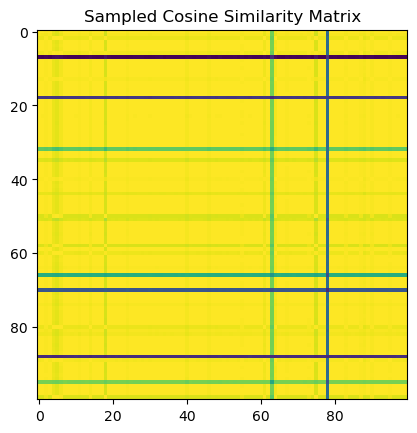

In [36]:
import numpy as np
import matplotlib.pyplot as plt

sample_size = 100  
sampled_indices = np.random.choice(similarity_matrix.shape[0], size=sample_size, replace=False)
sampled_matrix = similarity_matrix[sampled_indices][:, sampled_indices]

plt.imshow(sampled_matrix, cmap='viridis')
plt.title('Sampled Cosine Similarity Matrix')
plt.show()

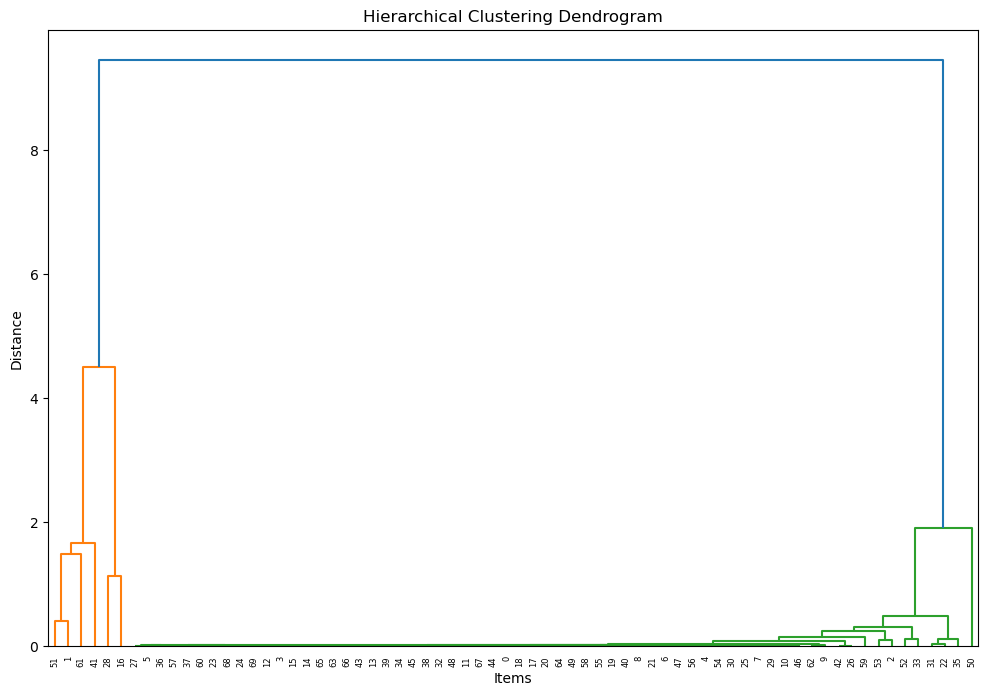

In [52]:
from scipy.cluster.hierarchy import linkage, dendrogram

sample_size = 70 
sampled_indices = np.random.choice(similarity_matrix.shape[0], size=sample_size, replace=False)
sampled_matrix = similarity_matrix[sampled_indices][:, sampled_indices]


linkage_matrix = linkage(sampled_matrix, method='complete')

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=np.arange(sampled_matrix.shape[0]), orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Items')
plt.ylabel('Distance')
plt.show()

![text](https://media.tenor.com/MBDLgfSd_UgAAAAC/the-end-gif.gif)